# 注意力机制中缩放因子(sqrt(d))的作用

在注意力机制中，查询向量(q)和键向量(k)的点积(q·k)会随着维度d的增大而变得非常大，这会导致softmax函数的输出出现梯度消失问题。为了解决这个问题，需要对注意力分数进行缩放。



In [1]:
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy

# 设置随机种子以保证可重复性
torch.manual_seed(0)

In [2]:
# =============================================
# 第一部分：展示注意力分数缩放的重要性
# =============================================

def demonstrate_scaling_effect():
    """展示不同缩放方式对注意力分数的影响"""
    d = 1024  # 特征维度
    n = 100   # 序列长度
    
    # 创建测试数据（服从标准正态分布）
    q = torch.randn(1, d)  # 查询向量 (1×d)
    k = torch.randn(1, d)  # 键向量 (1×d)
    Q = torch.randn(n, d)  # 多查询向量 (n×d)
    K = torch.randn(n, d)  # 多键向量 (n×d)
    
    print("\n=== 数据统计 ===")
    print(f"q - 均值: {q.mean():.4f}, 方差: {q.var():.4f}")
    print(f"k - 均值: {k.mean():.4f}, 方差: {k.var():.4f}")
    print(f"Q - 均值: {Q.mean():.4f}, 方差: {Q.var():.4f}")
    print(f"K - 均值: {K.mean():.4f}, 方差: {K.var():.4f}")
    
    # 计算不同缩放方式的注意力分数
    print("\n=== 单个向量注意力分数 ===")
    raw_score = q @ k.t()
    score_d = raw_score / d
    score_sqrt_d = raw_score / math.sqrt(d)
    
    print(f"原始分数: {raw_score.item():.4f} (值过大)")
    print(f"除以d: {score_d.item():.4f} (缩放过度)")
    print(f"除以√d: {score_sqrt_d.item():.4f} (理想范围)")
    
    # 计算多向量的统计特性
    print("\n=== 多向量注意力分数统计 ===")
    scores = q @ K.t()
    scores_d = scores / d
    scores_sqrt_d = scores / math.sqrt(d)
    
    print(f"原始分数 - 均值: {scores.mean():.4f}, 方差: {scores.var():.4f}")
    print(f"除以d - 均值: {scores_d.mean():.4f}, 方差: {scores_d.var():.4f}")
    print(f"除以√d - 均值: {scores_sqrt_d.mean():.4f}, 方差: {scores_sqrt_d.var():.4f}")
    
    # 比较softmax输出
    print("\n=== Softmax输出比较 ===")
    softmax_raw = F.softmax(scores, dim=1)
    softmax_d = F.softmax(scores_d, dim=1)
    softmax_sqrt_d = F.softmax(scores_sqrt_d, dim=1)
    
    print(f"原始softmax - 均值: {softmax_raw.mean():.4f}, 方差: {softmax_raw.var():.4f}")
    print(f"除以d - 均值: {softmax_d.mean():.4f}, 方差: {softmax_d.var():.4f} (方差过小)")
    print(f"除以√d - 均值: {softmax_sqrt_d.mean():.4f}, 方差: {softmax_sqrt_d.var():.4f} (理想)")

demonstrate_scaling_effect()


=== 数据统计 ===
q - 均值: 0.0322, 方差: 1.0567
k - 均值: -0.0057, 方差: 1.0215
Q - 均值: -0.0028, 方差: 1.0012
K - 均值: -0.0047, 方差: 0.9994

=== 单个向量注意力分数 ===
原始分数: -19.6923 (值过大)
除以d: -0.0192 (缩放过度)
除以√d: -0.6154 (理想范围)

=== 多向量注意力分数统计 ===
原始分数 - 均值: 0.1173, 方差: 960.1986
除以d - 均值: 0.0001, 方差: 0.0009
除以√d - 均值: 0.0037, 方差: 0.9377

=== Softmax输出比较 ===
原始softmax - 均值: 0.0100, 方差: 0.0067
除以d - 均值: 0.0100, 方差: 0.0000 (方差过小)
除以√d - 均值: 0.0100, 方差: 0.0001 (理想)


In [3]:
# =============================================
# 第二部分：梯度分析
# =============================================

def analyze_gradients():
    """分析不同缩放方式下的梯度情况"""
    d = 512
    n = 100
    q = torch.randn(1, d)
    K = torch.randn(n, d)
    
    print("\n=== 梯度分析 ===")
    
    # 不缩放（梯度消失）
    s = q @ K.t()
    s = F.softmax(s, dim=1)
    ds = torch.diag(s[0]) - s.t() @ s
    print("不缩放时的梯度样本:", ds[0, :5].data)
    
    # 除以d（梯度存在但可能过小）
    s = q @ K.t() / d
    s = F.softmax(s, dim=1)
    ds = torch.diag(s[0]) - s.t() @ s
    print("除以d的梯度样本:", ds[0, :5].data)
    
    # 除以√d（理想梯度）
    s = q @ K.t() / math.sqrt(d)
    s = F.softmax(s, dim=1)
    ds = torch.diag(s[0]) - s.t() @ s
    print("除以√d的梯度样本:", ds[0, :5].data)

analyze_gradients()


=== 梯度分析 ===
不缩放时的梯度样本: tensor([ 4.5087e-18, -4.3109e-32, -7.8893e-43,  0.0000e+00, -3.9657e-43])
除以d的梯度样本: tensor([ 1.0041e-02, -1.0445e-04, -9.9526e-05, -9.4726e-05, -9.9392e-05])
除以√d的梯度样本: tensor([ 9.2669e-03, -1.2276e-04, -4.1162e-05, -1.3453e-05, -3.9930e-05])


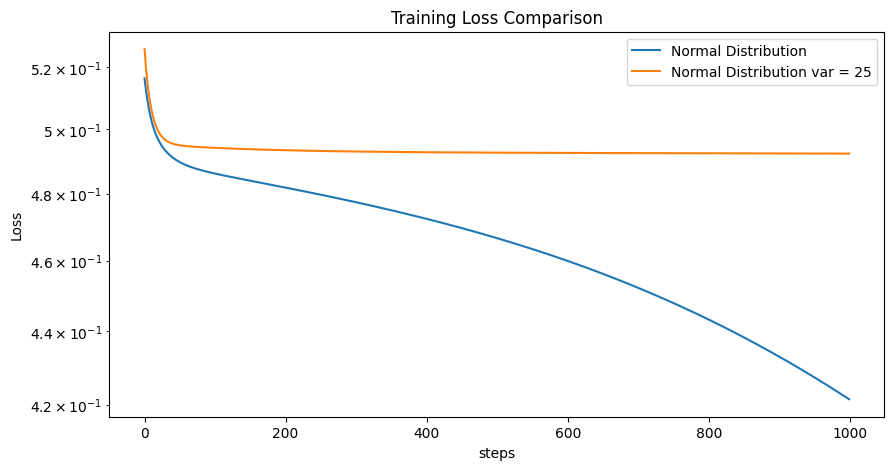


=== 训练结果 ===
标准正态输入(方差1.0) - 最终损失: 0.4215
缩放正态输入(方差大) - 最终损失: 0.4924


In [5]:
# =============================================
# 第三部分：输入分布对训练的影响
# =============================================

class SimpleNet(torch.nn.Module):
    """简单的神经网络用于演示输入分布的影响"""
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return self.fc2(x)

def train_and_compare():
    """比较不同输入分布下的训练效果"""
    n_samples = 1000
    epochs = 1000
    
    # 生成不同分布的数据
    X_normal = torch.randn(n_samples, 1)          # 标准正态分布
    X_scaled = torch.randn(n_samples, 1) * 5      # 方差较大的正态分布
    y = torch.sin(X_normal * 3.14)                # 目标函数
    
    # 创建模型副本
    model_normal = SimpleNet()
    model_scaled = deepcopy(model_normal)
    
    # 训练配置
    criterion = torch.nn.MSELoss()
    optimizer_normal = torch.optim.SGD(model_normal.parameters(), lr=0.01)
    optimizer_scaled = torch.optim.SGD(model_scaled.parameters(), lr=0.01)
    
    # 训练函数
    def train(model, optimizer, X):
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses
    
    # 训练模型
    losses_normal = train(model_normal, optimizer_normal, X_normal)
    losses_scaled = train(model_scaled, optimizer_scaled, X_scaled)
    
    # 绘制训练曲线
    plt.figure(figsize=(10, 5))
    plt.plot(losses_normal, label='Normal Distribution')
    plt.plot(losses_scaled, label='Normal Distribution var = 25')
    plt.xlabel('steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.yscale('log')  # 使用对数刻度以更好地显示差异
    plt.show()
    
    print("\n=== 训练结果 ===")
    # 方差为1的输入分布数据，拟合的loss更低
    print(f"标准正态输入(方差1.0) - 最终损失: {losses_normal[-1]:.4f}")
    print(f"缩放正态输入(方差大) - 最终损失: {losses_scaled[-1]:.4f}")

train_and_compare()